In [1]:
import tia.analysis.ta as ta
import tia.analysis.talib_wrapper as talib
import pandas as pd
from pandas.io.data import get_data_yahoo
from tia.analysis.model import SingleAssetPortfolio, PortfolioPricer, load_yahoo_stock, PortfolioSummary
from tia.analysis.model.ret import RoiiRetCalculator
from tia.util.fmt import DynamicColumnFormatter, DynamicRowFormatter, new_dynamic_formatter
import matplotlib.pyplot as plt

In [2]:
# drop adj close & volume for example sake 
msft = load_yahoo_stock('MSFT', start='1/1/2010')

C:\Anaconda\lib\site-packages\pandas\tseries\base.py:363: FutureWarning: using '-' to provide set differences with datetimelike Indexes is deprecated, use .difference()
  "use .difference()",FutureWarning)
C:\Anaconda\lib\site-packages\pandas\core\index.py:1196: FutureWarning: using '-' to provide set differences with Indexes is deprecated, use .difference()
  "use .difference()",FutureWarning)


In [3]:
%matplotlib inline

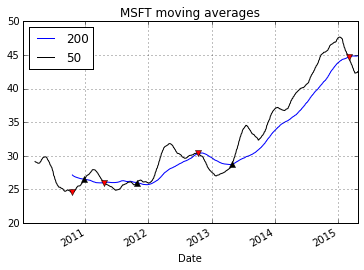

In [4]:
# build signal when 50d crosses 200d
moving_avgs = pd.DataFrame({'50': ta.sma(msft.pxs.close, 50), '200': ta.sma(msft.pxs.close, 200)})
signal = ta.cross_signal(moving_avgs['50'], moving_avgs['200']).dropna()
# keep only entry
entry_signal = signal.copy()
entry_signal[signal.shift(1) == signal]  = 0 
entry_signal = entry_signal[entry_signal != 0]
# show when the signal triggers
moving_avgs.plot(color=['b', 'k'], title='MSFT moving averages')
for i, v in entry_signal.iteritems():
    if v == -1:
        plt.plot(i, moving_avgs['50'][i], 'rv')
    else:
        plt.plot(i, moving_avgs['50'][i], 'k^')

In [5]:
# Can get the set of trades created by this signal
trades = ta.Signal(signal).close_to_close(msft.pxs.close)
trades

[<Trade(1, qty=1.0, px=28.07, ts=2010-12-27 00:00:00)>,
 <Trade(2, qty=-1.0, px=25.15, ts=2011-04-19 00:00:00)>,
 <Trade(3, qty=-1.0, px=25.15, ts=2011-04-19 00:00:00)>,
 <Trade(4, qty=1.0, px=26.59, ts=2011-10-26 00:00:00)>,
 <Trade(5, qty=1.0, px=26.59, ts=2011-10-26 00:00:00)>,
 <Trade(6, qty=-1.0, px=29.49, ts=2012-10-16 00:00:00)>,
 <Trade(7, qty=-1.0, px=29.49, ts=2012-10-16 00:00:00)>,
 <Trade(8, qty=1.0, px=32.61, ts=2013-04-29 00:00:00)>,
 <Trade(9, qty=1.0, px=32.61, ts=2013-04-29 00:00:00)>,
 <Trade(10, qty=-1.0, px=43.11, ts=2015-03-05 00:00:00)>,
 <Trade(11, qty=-1.0, px=43.11, ts=2015-03-05 00:00:00)>]

In [6]:
# construct a portfolio from the trades
port = SingleAssetPortfolio(msft, trades, ret_calc=RoiiRetCalculator())

In [7]:
# Show each of the individial transactions
port.txns.frame.tail()

,date,txn_ts,pid,tid,txn_qty,txn_px,txn_fees,txn_premium,open_val,pos,txn_intent,txn_action
seq,,,,,,,,,,,,
6,2012-10-16,2012-10-16,4,7,-1,29.49,0,29.49,29.49,-1,1,3
7,2013-04-29,2013-04-29,4,8,1,32.61,0,-32.61,0.00,0,2,4
8,2013-04-29,2013-04-29,5,9,1,32.61,0,-32.61,-32.61,1,1,1
9,2015-03-05,2015-03-05,5,10,-1,43.11,0,43.11,0.00,0,2,2
10,2015-03-05,2015-03-05,6,11,-1,43.11,0,43.11,43.11,-1,1,3


In [8]:
# Show the position summary
port.positions.frame

,side,open_dt,close_dt,open_qty,open_px,close_px,open_premium,pl,ret,duration,ntxns,state
pid,,,,,,,,,,,,
1,Long,2010-12-27,2011-04-19,1,28.07,25.15,-28.07,-2.76,-0.098326,80,2,Closed
2,Short,2011-04-19,2011-10-26,-1,25.15,26.59,25.15,-1.76,-0.069980,133,2,Closed
3,Long,2011-10-26,2012-10-16,1,26.59,29.49,-26.59,3.70,0.139150,246,2,Closed
4,Short,2012-10-16,2013-04-29,-1,29.49,32.61,29.49,-3.58,-0.121397,132,2,Closed
5,Long,2013-04-29,2015-03-05,1,32.61,43.11,-32.61,12.70,0.389451,467,2,Closed
6,Short,2015-03-05,2015-04-24,-1,43.11,NaN,43.11,-4.76,-0.110415,36,1,Open


In [9]:
# Transaction Level Profit & Loss
port.pl.txn_frame.tail(5)

,date,pos,pid,tid,txn_qty,txn_px,txn_fees,txn_premium,txn_intent,txn_action,close,open_val,mkt_val,total_val,dvds,fees,rpl_gross,rpl,upl,pl
1336,2015-04-20,-1,6,0,NaN,NaN,0,0,0,0,42.91,43.11,-42.91,0,0,0,0,0,-1.29,-1.29
1337,2015-04-21,-1,6,0,NaN,NaN,0,0,0,0,42.64,43.11,-42.64,0,0,0,0,0,0.27,0.27
1338,2015-04-22,-1,6,0,NaN,NaN,0,0,0,0,42.99,43.11,-42.99,0,0,0,0,0,-0.35,-0.35
1339,2015-04-23,-1,6,0,NaN,NaN,0,0,0,0,43.34,43.11,-43.34,0,0,0,0,0,-0.35,-0.35
1340,2015-04-24,-1,6,0,NaN,NaN,0,0,0,0,47.87,43.11,-47.87,0,0,0,0,0,-4.53,-4.53


In [10]:
# Daily Profit & Loss Frame
port.pl.dly_frame.tail(5)

,dvds,fees,rpl_gross,rpl,upl,pl
2015-04-20,0,0,0,0,-1.29,-1.29
2015-04-21,0,0,0,0,0.27,0.27
2015-04-22,0,0,0,0,-0.35,-0.35
2015-04-23,0,0,0,0,-0.35,-0.35
2015-04-24,0,0,0,0,-4.53,-4.53


In [11]:
# Show Profit & Loss Report
DynamicColumnFormatter(port.pl.report_by_year())

,mpl avg,mpl std ann,maxdd,maxdd dt,avg dd,best month,worst month,best day,worst day,nmonths
2010,(0),0.2,(0.2),30-Dec-10,(0.2),0,(0.2),0.1,(0.1),12
2011,(0.4),3.6,(7.4),25-Nov-11,(2.8),1.7,(1.7),1.4,(1.1),12
2012,0.6,5.9,(4.2),01-Jun-12,(0.6),3.6,(2.6),1.6,(1),12
2013,(0),6.8,(7.4),06-Sep-13,(2.3),3,(3.5),2.4,(4),12
2014,0.8,3.9,(4.8),16-Oct-14,(1.1),2.7,(1.4),1.8,(1.8),12
2015,(1.9),19,(8.9),24-Apr-15,(5),3.8,(7.2),1.4,(4.5),4
ltd,0.1,6.5,(10.6),24-Apr-15,(1.7),3.8,(7.2),2.4,(4.5),64


In [12]:
# Show Position Information
port.positions.stats

,positions
cnt,6
win_pct,33.33%
ret_avg,2.14%
ret_std,20.48%
ret_min,(12.14%)
ret_max,38.95%
pl_avg,59%
pl_std,6.62
pl_min,(4.76)
pl_max,12.70


c:\projects\good_to_see_you\tia\tia\analysis\perf.py:93: UserWarning: frequency not set. guessed it to be B
  warnings.warn('frequency not set. guessed it to be %s' % freq)


(<matplotlib.text.Text at 0xcfba390>, <matplotlib.text.Text at 0xcfdd198>)

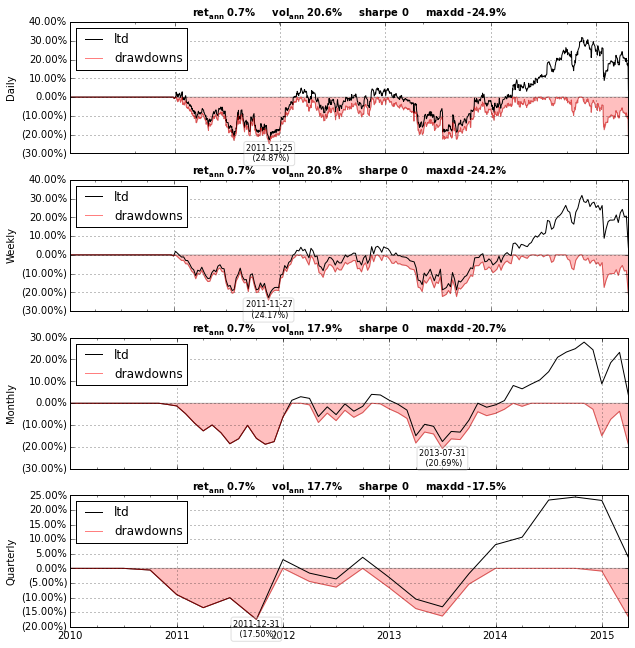

In [13]:
# Ability to show different return frequencies
fig, axes = plt.subplots(4, 1, figsize=(10, 12))
ax = port.performance.dly_details.plot_ltd(ax=axes[0])
port.performance.weekly_details.plot_ltd(ax=axes[1])
port.performance.monthly_details.plot_ltd(ax=axes[2])
port.performance.quarterly_details.plot_ltd(ax=axes[3])

axes[0].set_ylabel('Daily'), axes[1].set_ylabel('Weekly')
axes[2].set_ylabel('Monthly'), axes[3].set_ylabel('Quarterly')

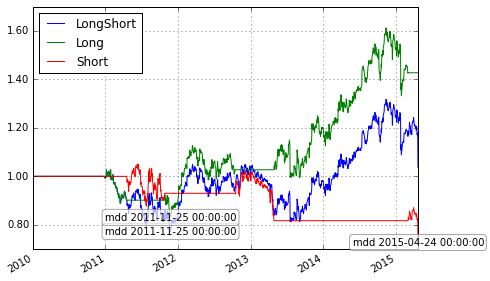

In [14]:
# 
# Show the Return on a dollar
#
port.performance.dly_details.plot_ret_on_dollar(label='LongShort')
port.long.performance.dly_details.plot_ret_on_dollar(label='Long')
port.short.performance.dly_details.plot_ret_on_dollar(label='Short')
plt.legend(loc='upper left')

In [15]:
# Show a return report
F = new_dynamic_formatter(method='col', pcts=1, trunc_dot_zeros=1)
# Ability to added custom groupps
F(port.performance.report_by_year(prior_n_yrs=2, ranges=[(2011, 2012)]))

,ltd ann,mret avg,mret std ann,sharpe ann,sortino,maxdd,maxdd dt,avg dd,best month,worst month,nmonths
2010,(0.6%),(0%),0.6%,(1),(0.3),(0.8%),30-Dec-10,(0.8%),0,(0.6%),12
2011,(17%),(1.5%),14.8%,(1.2),(1.1),(24.9%),25-Nov-11,(9.3%),0.1,(6.6%),12
2012,25.8%,2.1%,20.3%,1.3,1.8,(12.6%),01-Jun-12,(2.1%),0.1,(8.1%),12
2013,(5.4%),(0.3%),21%,(0.3),(0.3),(22.2%),06-Sep-13,(8.5%),0.1,(12.1%),12
2014,26.7%,2%,9%,3,3.5,(9.7%),16-Oct-14,(2.5%),0.1,(2.7%),12
2015,(42%),(3.9%),42.1%,(1),(0.9),(18.5%),24-Apr-15,(10.4%),0.1,(15.8%),4
2011-2012,2.2%,0.3%,18.5%,0.1,0.1,(24.9%),25-Nov-11,(7.8%),0.1,(8.1%),24
past 2yrs,(0%),0.2%,21.4%,(0),(0),(22.2%),06-Sep-13,(3.9%),0.1,(15.8%),28
ltd,0.7%,0.2%,17.9%,0,0,(24.9%),25-Nov-11,(5%),0.1,(15.8%),64


In [16]:
# Build a custom report which shows return information and position level information in single frame
RF = new_dynamic_formatter('row', pcts=1, trunc_dot_zeros=1)

summary = PortfolioSummary()
summary.include_long_short().include_win_loss()
RF(summary(port).T)

lvl1                               All                       \
lvl2                               All               winner   
port ltd ann                         0                  0.1   
     mret avg                        0                    0   
     mret avg ann                    0                  0.1   
     mret std ann                  0.2                  0.1   
     sharpe ann                   3.9%                  66%   
     sortino                      3.4%                53.1%   
     maxdd                     (24.9%)              (17.4%)   
     maxdd dt      2011-11-25 00:00:00  2015-01-30 00:00:00   
     avg dd                       (5%)               (3.2%)   
     nmonths                        64                   64   
pos  cnt                             6                    2   
     win cnt                         2                    2   
     lose cnt                        4                    0   
     winpct                        0.3                    1   
     ret avg                      2.1%                26.4%   
     ret std                     20.5%                17.7%   
     ret min                   (12.1%)                13.9%   
     ret max                     38.9%                38.9%   
     dur avg                     182.3                356.5   
     dur max                       467                  467   

lvl1                                                   long  \
lvl2                             loser                  All   
port ltd ann                     (0.1)                  0.1   
     mret avg                      (0)                    0   
     mret avg ann                (0.1)                  0.1   
     mret std ann                  0.1                  0.1   
     sharpe ann                (65.5%)                49.4%   
     sortino                   (33.9%)                45.2%   
     maxdd                     (36.3%)              (19.2%)   
     maxdd dt      2015-04-24 00:00:00  2011-11-25 00:00:00   
     avg dd                      (10%)               (3.4%)   
     nmonths                        64                   64   
pos  cnt                             4                    3   
     win cnt                         0                    2   
     lose cnt                        4                    1   
     winpct                          0                  0.7   
     ret avg                     (10%)                14.3%   
     ret std                      2.2%                24.4%   
     ret min                   (12.1%)               (9.8%)   
     ret max                      (7%)                38.9%   
     dur avg                      95.2                264.3   
     dur max                       133                  467   

lvl1                                                         \
lvl2                            winner                loser   
port ltd ann                       0.1                  (0)   
     mret avg                        0                  (0)   
     mret avg ann                  0.1                  (0)   
     mret std ann                  0.1                    0   
     sharpe ann                    66%              (77.2%)   
     sortino                     53.1%              (21.2%)   
     maxdd                     (17.4%)              (13.6%)   
     maxdd dt      2015-01-30 00:00:00  2011-03-17 00:00:00   
     avg dd                     (3.2%)               (4.4%)   
     nmonths                        64                   64   
pos  cnt                             2                    1   
     win cnt                         2                    0   
     lose cnt                        0                    1   
     winpct                          1                    0   
     ret avg                     26.4%               (9.8%)   
     ret std                     17.7%                  nan   
     ret min                     13.9%               (9.8%)   
     ret max                 